<a href="https://colab.research.google.com/github/sanjeev200009/Academic_Risk_Prediction/blob/main/Academic_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Step 1: Install required packages
!pip install pandas scikit-learn numpy matplotlib seaborn streamlit joblib

In [35]:
# Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from joblib import dump, load
import streamlit as st
import os
import zipfile

# Install pyngrok if not already installed
!pip install pyngrok --quiet
from pyngrok import ngrok

In [36]:
# Step 3: Load and preprocess data
def load_and_preprocess_data():
    # Load UCI Student Performance Dataset
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
    !wget {url}
    !unzip student.zip

    # Read data
    math_df = pd.read_csv('student-mat.csv', sep=';')
    portuguese_df = pd.read_csv('student-por.csv', sep=';')

    # Combine datasets and remove duplicates
    combined_df = pd.concat([math_df, portuguese_df]).drop_duplicates(keep='first')
    return combined_df


In [37]:
# Step 4: Feature engineering for Sri Lankan context
def sri_lankan_feature_engineering(df):
    # Simulate Sri Lankan-specific attributes
    np.random.seed(42)

    # Add region (Urban, Rural, Estate)
    regions = ['Urban', 'Rural', 'Estate']
    df['region'] = np.random.choice(regions, size=len(df), p=[0.18, 0.77, 0.05])

    # Add ethnicity (Sinhala, Tamil, Muslim, Other)
    ethnicities = ['Sinhala', 'Tamil', 'Muslim', 'Other']
    df['ethnicity'] = np.random.choice(ethnicities, size=len(df), p=[0.75, 0.11, 0.09, 0.05])

    # Add economic status (Low, Middle, High)
    economic_status = ['Low', 'Middle', 'High']
    df['economic_status'] = np.random.choice(economic_status, size=len(df), p=[0.45, 0.50, 0.05])

    # Create academic risk target (G3 < 10 considered at-risk)
    df['academic_risk'] = (df['G3'] < 10).astype(int)

    # Feature selection
    features = [
        'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
        'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
        'G1', 'G2', 'region', 'ethnicity', 'economic_status'
    ]

    return df[features + ['academic_risk']]


In [38]:
# Step 5: Data preprocessing pipeline
def preprocess_data(df):
    # Encode categorical features
    categorical_cols = ['region', 'ethnicity', 'economic_status']
    label_encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Split data
    X = df.drop('academic_risk', axis=1)
    y = df['academic_risk']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale numerical features
    scaler = StandardScaler()
    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    return X_train, X_test, y_train, y_test, scaler, label_encoders

In [39]:
# Step 6: Model training and evaluation
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Logistic Regression": LogisticRegression(random_state=42)
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        results[name] = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "confusion_matrix": confusion_matrix(y_test, y_pred),
            "model": model
        }

    return results

In [40]:
# Step 7: Visualization and reporting
def visualize_results(results, X_train):
    # Performance comparison
    metrics_df = pd.DataFrame()
    for model, scores in results.items():
        metrics_df = pd.concat([metrics_df, pd.DataFrame({
            'Model': model,
            'Accuracy': scores['accuracy'],
            'Precision': scores['precision'],
            'Recall': scores['recall'],
            'F1-Score': scores['f1']
        }, index=[0])], ignore_index=True)

    print("\nModel Performance Comparison:")
    print(metrics_df)

    # Confusion matrix visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, (model, scores) in enumerate(results.items()):
        sns.heatmap(scores['confusion_matrix'], annot=True, fmt='d',
                    cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_title(f'{model} Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.show()

    # Feature importance for best model
    best_model_name = max(results, key=lambda x: results[x]['f1'])
    best_model = results[best_model_name]['model']

    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': best_model.feature_importances_
        }).sort_values('Importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
        plt.title('Top 10 Important Features')
        plt.savefig('feature_importance.png')
        plt.show()

Starting Academic Risk Prediction Project...
Loading and preprocessing data...
--2025-07-20 14:57:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘student.zip’

student.zip             [ <=>                ]  20.00K  --.-KB/s    in 0.008s  

2025-07-20 14:57:40 (2.41 MB/s) - ‘student.zip’ saved [20478]

Archive:  student.zip
  inflating: student-mat.csv         
  inflating: student-por.csv         
  inflating: student-merge.R         
  inflating: student.txt             

Engineering Sri Lankan-specific features...

Preprocessing data for modeling...

Training and evaluating models...

Generating visualizations and reports...

Model Performance Comparison:
                 Model  Accuracy  Precision    Recall  F1-Sc

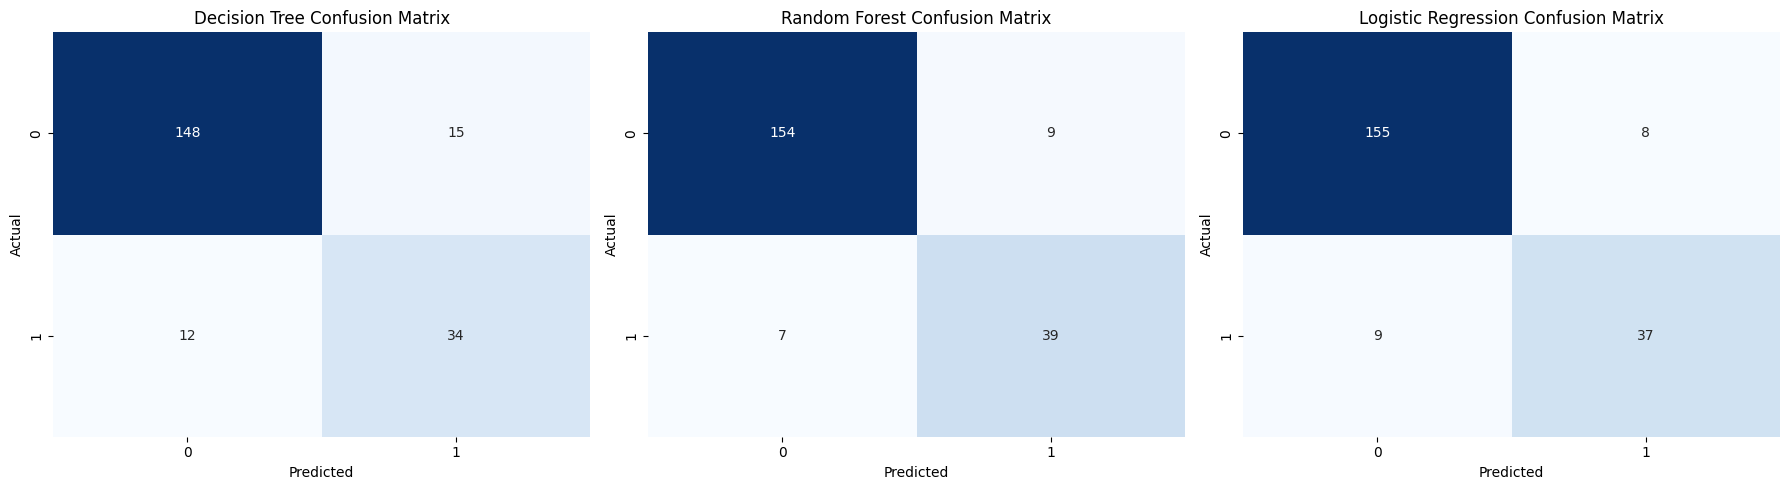

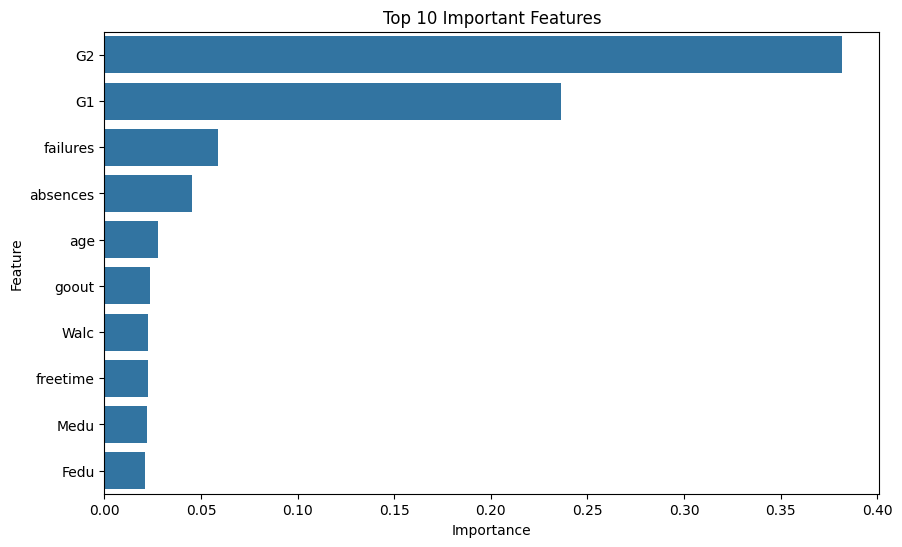


Saving best model (Random Forest) and preprocessing artifacts...

Project workflow completed successfully!


In [41]:
# Step 8: Main workflow
def main():
    print("Starting Academic Risk Prediction Project...")
    print("Loading and preprocessing data...")
    df = load_and_preprocess_data()

    print("\nEngineering Sri Lankan-specific features...")
    df = sri_lankan_feature_engineering(df)

    print("\nPreprocessing data for modeling...")
    X_train, X_test, y_train, y_test, scaler, label_encoders = preprocess_data(df)

    print("\nTraining and evaluating models...")
    results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

    print("\nGenerating visualizations and reports...")
    visualize_results(results, X_train)

    # Save best model and preprocessing artifacts
    best_model_name = max(results, key=lambda x: results[x]['f1'])
    best_model = results[best_model_name]['model']

    print(f"\nSaving best model ({best_model_name}) and preprocessing artifacts...")
    dump(best_model, 'academic_risk_model.joblib')
    dump(scaler, 'scaler.joblib')
    dump(label_encoders, 'label_encoders.joblib')

    print("\nProject workflow completed successfully!")

if __name__ == "__main__":
    main()

In [42]:
# Step 9: Prepare Streamlit deployment template
%%file app.py
import streamlit as st
import pandas as pd
import joblib

# Load artifacts
model = joblib.load('academic_risk_model.joblib')
scaler = joblib.load('scaler.joblib')
label_encoders = joblib.load('label_encoders.joblib')

# Streamlit app
st.title('Academic Risk Prediction for Sri Lankan Students')
st.write("""
This tool helps educators identify students at risk of academic failure
based on their academic and demographic characteristics.
""")

# Input form
st.sidebar.header('Student Information')

def user_input_features():
    age = st.sidebar.slider('Age', 15, 22, 16)
    studytime = st.sidebar.select_slider('Weekly Study Time (hours)', [1, 2, 3, 4], 2)
    absences = st.sidebar.slider('Absences (last quarter)', 0, 30, 5)
    g1 = st.sidebar.slider('First Period Grade (G1)', 0, 20, 10)
    g2 = st.sidebar.slider('Second Period Grade (G2)', 0, 20, 10)
    region = st.sidebar.selectbox('Region', ['Urban', 'Rural', 'Estate'])
    ethnicity = st.sidebar.selectbox('Ethnicity', ['Sinhala', 'Tamil', 'Muslim', 'Other'])
    economic_status = st.sidebar.selectbox('Economic Status', ['Low', 'Middle', 'High'])

    return pd.DataFrame({
        'age': [age],
        'studytime': [studytime],
        'absences': [absences],
        'G1': [g1],
        'G2': [g2],
        'region': [region],
        'ethnicity': [ethnicity],
        'economic_status': [economic_status]
    })

input_df = user_input_features()

# Preprocess input
def preprocess_input(df):
    # Encode categorical features
    for col in ['region', 'ethnicity', 'economic_status']:
        le = label_encoders[col]
        df[col] = le.transform(df[col])

    # Add missing columns with default values
    required_columns = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
                       'G1', 'G2', 'region', 'ethnicity', 'economic_status']

    for col in required_columns:
        if col not in df.columns:
            df[col] = 0  # Default value for missing features

    # Scale features
    df = pd.DataFrame(scaler.transform(df), columns=df.columns)
    return df[required_columns]

# Prediction
if st.sidebar.button('Predict Academic Risk'):
    processed_input = preprocess_input(input_df.copy())
    prediction = model.predict(processed_input)
    prediction_proba = model.predict_proba(processed_input)

    st.subheader('Prediction')
    risk_status = "At Risk" if prediction[0] == 1 else "Not At Risk"
    st.write(f'Prediction: **{risk_status}**')
    st.write(f'Probability of being at risk: {prediction_proba[0][1]:.2f}')

    st.subheader('Interpretation')
    if prediction[0] == 1:
        st.warning('This student is predicted to be at academic risk. Consider interventions:')
        st.write('- Additional tutoring sessions')
        st.write('- Parent-teacher conference')
        st.write('- Attendance monitoring')
    else:
        st.success('This student is not currently at significant academic risk')
        st.write('Recommendations:')
        st.write('- Continue regular monitoring')
        st.write('- Maintain current support systems')

# Show input data
st.subheader('Student Data Summary')
st.write(input_df)

# How to run the Streamlit app
st.sidebar.markdown("""
**How to Use:**
1. Adjust student parameters using the sliders
2. Click 'Predict Academic Risk'
3. View results in the main panel
""")

Writing app.py


In [43]:
# Step 9: Prepare Streamlit deployment template
%%file app.py
import streamlit as st
import pandas as pd
import joblib

# Load artifacts
model = joblib.load('academic_risk_model.joblib')
scaler = joblib.load('scaler.joblib')
label_encoders = joblib.load('label_encoders.joblib')

# Streamlit app
st.title('Academic Risk Prediction for Sri Lankan Students')
st.write("""
This tool helps educators identify students at risk of academic failure
based on their academic and demographic characteristics.
""")

# Input form
st.sidebar.header('Student Information')

def user_input_features():
    age = st.sidebar.slider('Age', 15, 22, 16)
    studytime = st.sidebar.select_slider('Weekly Study Time (hours)', [1, 2, 3, 4], 2)
    absences = st.sidebar.slider('Absences (last quarter)', 0, 30, 5)
    g1 = st.sidebar.slider('First Period Grade (G1)', 0, 20, 10)
    g2 = st.sidebar.slider('Second Period Grade (G2)', 0, 20, 10)
    region = st.sidebar.selectbox('Region', ['Urban', 'Rural', 'Estate'])
    ethnicity = st.sidebar.selectbox('Ethnicity', ['Sinhala', 'Tamil', 'Muslim', 'Other'])
    economic_status = st.sidebar.selectbox('Economic Status', ['Low', 'Middle', 'High'])

    return pd.DataFrame({
        'age': [age],
        'studytime': [studytime],
        'absences': [absences],
        'G1': [g1],
        'G2': [g2],
        'region': [region],
        'ethnicity': [ethnicity],
        'economic_status': [economic_status]
    })

input_df = user_input_features()

# Preprocess input
def preprocess_input(df):
    # Encode categorical features
    for col in ['region', 'ethnicity', 'economic_status']:
        le = label_encoders[col]
        df[col] = le.transform(df[col])

    # Add missing columns with default values and ensure correct order
    required_columns = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
                       'G1', 'G2', 'region', 'ethnicity', 'economic_status']

    for col in required_columns:
        if col not in df.columns:
            df[col] = 0  # Default value for missing features

    # Ensure the order of columns matches the training data
    df = df[required_columns]

    # Scale features
    df = pd.DataFrame(scaler.transform(df), columns=df.columns)
    return df[required_columns]

# Prediction
if st.sidebar.button('Predict Academic Risk'):
    processed_input = preprocess_input(input_df.copy())
    prediction = model.predict(processed_input)
    prediction_proba = model.predict_proba(processed_input)

    st.subheader('Prediction')
    risk_status = "At Risk" if prediction[0] == 1 else "Not At Risk"
    st.write(f'Prediction: **{risk_status}**')
    st.write(f'Probability of being at risk: {prediction_proba[0][1]:.2f}')

    st.subheader('Interpretation')
    if prediction[0] == 1:
        st.warning('This student is predicted to be at academic risk. Consider interventions:')
        st.write('- Additional tutoring sessions')
        st.write('- Parent-teacher conference')
        st.write('- Attendance monitoring')
    else:
        st.success('This student is not currently at significant academic risk')
        st.write('Recommendations:')
        st.write('- Continue regular monitoring')
        st.write('- Maintain current support systems')

# Show input data
st.subheader('Student Data Summary')
st.write(input_df)

# How to run the Streamlit app
st.sidebar.markdown("""
**How to Use:**
1. Adjust student parameters using the sliders
2. Click 'Predict Academic Risk'
3. View results in the main panel
""")

Overwriting app.py


In [44]:
!ls

academic_risk_model.joblib  label_encoders.joblib  student-por.csv
app.py			    scaler.joblib	   student.txt
confusion_matrices.png	    student-mat.csv	   student.zip
feature_importance.png	    student-merge.R


In [45]:
!pip install streamlit pyngrok --quiet

In [46]:
import os

# Set ngrok token here (recommended: copy from ngrok dashboard and paste when prompted)
os.environ["NGROK_AUTH_TOKEN"] = input("Enter your NGROK Auth Token: ")

Enter your NGROK Auth Token: 303goQ9AshR3mCXm4FoxIjgvvLg_YjGJVDo3hCNuzoNL6PwP


In [48]:
from pyngrok import ngrok
import os

# Set your token securely (user must provide it)
NGROK_AUTH_TOKEN = os.getenv("NGROK_AUTH_TOKEN")

if not NGROK_AUTH_TOKEN:
    raise ValueError("Please set your NGROK_AUTH_TOKEN using os.environ or input before running this cell.")

# Authenticate ngrok
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Kill any existing tunnels
ngrok.kill()

# Open a tunnel on port 8501
public_url = ngrok.connect(8501)
print(f"🌐 Your Streamlit app is available at: {public_url}")

# Run Streamlit app
!streamlit run app.py &


🌐 Your Streamlit app is available at: NgrokTunnel: "https://983b31fdcb7a.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.227.60:8501



  Stopping...
